# **Project: Amazon Product Recommendation System**

# **Marks: 40**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Installing surprise library**

In [ ]:
!pip install --upgrade numpy==1.26.4
!pip install surprise

## **Importing the necessary libraries and overview of the dataset**

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns



from surprise.model_selection import KFold
from collections import defaultdict

from sklearn.metrics import mean_squared_error

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [ ]:
# Import dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Recommendation_systems/ratings_Electronics.csv', header = None)
df.columns = ['user_id', 'prod_id', 'rating', 'timestamp']
df = df.drop('timestamp', axis = 1)
df_copy = df.copy(deep = True)

**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [ ]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [ ]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [ ]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [ ]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [ ]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [ ]:
# Check the number of rows and columns and provide observations
rows, columns = df_final.shape
print("Num of rows: ", rows)
print("Num of columns: ", columns)

Num of rows:  65290
Num of columns:  3


**observations here:**

Rows: 65,290 (user-item interactions)

Columns: 3 ( user_id, item_id, rating)

### **Data types**

In [ ]:
# Check Data types and provide observations
# To count data types
print(df_final.dtypes)
df_final.dtypes.value_counts()

user_id     object
prod_id     object
rating     float64
dtype: object


,count
object,2
float64,1


**Observations here:**

user_id: Object type (representing user identifiers)

prod_id: Object type (representing product identifiers)

rating: Float64 type (numerical ratings)

### **Checking for missing values**

In [ ]:
# Check for missing values present and provide observations
print(df_final.isnull().sum())

user_id    0
prod_id    0
rating     0
dtype: int64


**Write your observations here:**

There are no missing values (all columns show 0 null values)

### **Summary Statistics**

In [ ]:
# Summary statistics of 'rating' variable and provide observations
df_final['rating'].describe().T

,rating
count,65290.000000
mean,4.294808
std,0.988915
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


**Observations here:**

**General Overview:**

The dataset contains 65,290 ratings, indicating a substantial sample size for analysis.

Ratings range from 1.0 lowest to 5.0 highest, meaning 5-point scale is used.

**Central Tendency:**

Mean Rating (4.29): The average rating is high, suggesting overall user satisfaction.

Median (50% = 5.0): Half of the ratings are the maximum score (5.0), reinforcing strong positive sentiment.

**Spread and Distribution:**

Standard Deviation (~0.99): Ratings exhibit moderate variability, with some dispersion around the mean.

Left-Skewed Distribution: The median (5.0) > mean (4.29), and the 75th percentile is also 5.0, indicating a concentration of high ratings with a tail of lower scores.

25th Percentile (4.0): 75% of ratings are 4.0 or higher, meaning that most users are highly satisfied.

### **Checking the rating distribution**

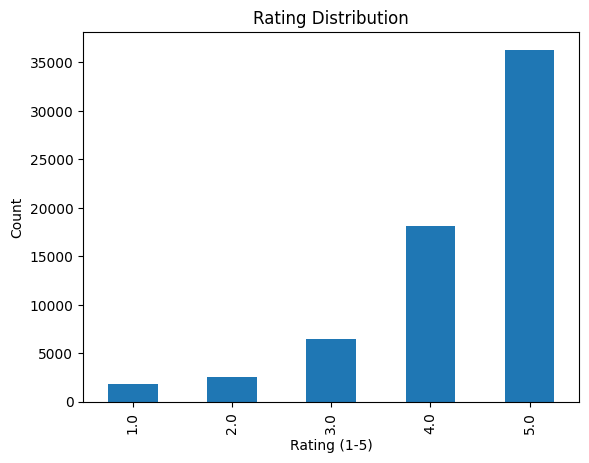

In [ ]:
df_final['rating'].value_counts().sort_index().plot(kind='bar')


plt.title('Rating Distribution')
plt.xlabel('Rating (1-5)')
plt.ylabel('Count')

plt.show()



**Observations:**
- Extreme positive bias. 5 star rating dominates followed by 4 star rating.
- Very few negative reviews.

This suggests either:

- Exceptionally high user satisfaction, or

- Potential bias (e.g., review incentives, voluntary response bias).

### **Checking the number of unique users and items in the dataset**

In [ ]:
# Number of total rows in the data and number of unique user id and product id in the data
# Number of unique products and users
unique_products = df_final['prod_id'].nunique()
total_ratings = len(df_final)
unique_users = df_final['user_id'].nunique()

print(f"Unique products: {unique_products}")
print(f"Total ratings: {total_ratings}")
print(f"Unique users: {unique_users}")
print(f"Avg no of ratings on popular products per user: {total_ratings/unique_users}")
print(f"Avg no rating of popular products: {total_ratings/unique_products}")

Unique products: 5689
Total ratings: 65290
Unique users: 1540
Avg no of ratings on popular products per user: 42.396103896103895
Avg no rating of popular products: 11.476533661451924


**Observations here:**

**Key Insights**

Highly engaged user base: Each user rated about 42 products on average, suggesting:

Power users dominate the dataset


Sparse product coverage: Only about 11 ratings per product on average, indicating:

Long-tail distribution (few popular items, many niche ones)

### **Users with the most number of ratings**

In [ ]:
# Top 10 users based on the number of ratings
top_users = df['user_id'].value_counts().head(10)
print(top_users)

user_id
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
ARBKYIVNYWK3C     296
Name: count, dtype: int64


**Observations here:**
The top 10 users in the dataset are exceptionally active, each contributing 300–520 ratings, far exceeding the average. The most active user alone has 520 ratings, nearly double the 10th-ranked user (296). This heavy concentration of reviews suggests potential biases—such as incentivized behavior or bot-like activity—that could skew recommendation models.

**Concerns:**

Hyper-active top users risk biasing recommendations; their behavior might need validation and modeling needs to adjust accordingly.

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [ ]:
# Calculate the average rating for each product
average_rating = df_final.groupby('prod_id')['rating'].mean()

# Calculate the count of ratings for each product
count_rating = df_final.groupby('prod_id')['rating'].count()

# Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({
    'average_rating': average_rating,
    'rating_count': count_rating
})

# Sort the dataframe by average of ratings in the descending order
final_rating = final_rating.sort_values('average_rating', ascending=False)

# See the first five records of the "final_rating" dataset
final_rating.head()

,average_rating,rating_count
prod_id,,
B00LGQ6HL8,5.0,5
B003DZJQQI,5.0,14
B005FDXF2C,5.0,7
B00I6CVPVC,5.0,7
B00B9KOCYA,5.0,8


In [ ]:
def get_top_products(df, n=5, min_interactions=5):
    """
    Returns top n products based on average rating,
    requiring minimum interactions (ratings) per product

    Parameters:
        df (DataFrame): Input dataframe with product ratings
        n (int): Number of top products to return
        min_interactions (int): Minimum required ratings per product

    Returns:
        DataFrame: Top n products sorted by average rating
    """
    # Calculate product statistic
    product_stats = df.groupby('prod_id')['rating'].agg(
        ['mean', 'count']
    ).rename(columns={
        'mean': 'avg_rating',
        'count': 'rating_count'
    })

    # Filter products with min interactions
    qualified_products = product_stats[
        product_stats['rating_count'] >= min_interactions
    ]

    # Sort by average rating (descending) and rating count (descending)
    top_products = qualified_products.sort_values(
        ['avg_rating', 'rating_count'],
        ascending=[False, False]
    ).head(n)

    return top_products



### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [ ]:
top_5_products50inter = get_top_products(df_final, n=5, min_interactions=50)
print(top_5_products50inter)

            avg_rating  rating_count
prod_id                             
B001TH7GUU    4.871795            78
B003ES5ZUU    4.864130           184
B0019EHU8G    4.855556            90
B006W8U2MU    4.824561            57
B000QUUFRW    4.809524            84


### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [ ]:
top_5_products100inter = get_top_products(df_final, n=5, min_interactions=100)
print(top_5_products100inter)

            avg_rating  rating_count
prod_id                             
B003ES5ZUU    4.864130           184
B000N99BBC    4.772455           167
B002WE6D44    4.770000           100
B007WTAJTO    4.701220           164
B002V88HFE    4.698113           106


We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [ ]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [ ]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [ ]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))
# Loading the rating dataset
data = Dataset.load_from_df(
    df_final[['user_id', 'prod_id', 'rating']],
    reader
)
# Splitting the data into train and test datasets
# Split into train/test (80%/20%)
trainset, testset = train_test_split(data, test_size=0.20)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [ ]:
# Declaring the similarity options
sim_options = {
    'name': 'cosine',    # Similarity metric
    'user_based': False,
    'min_support': 3      # Minimum common users for similarity
}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
model = KNNBasic(
    sim_options=sim_options,
    min_k=1,
    verbose=False,
    random_state=1
)

# Fit the model on the training data

model.fit(trainset)
# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
print("KNNBasic Model Evaluation:")
precision_recall_at_k(model)

KNNBasic Model Evaluation:
RMSE: 1.0378
Precision:  0.84
Recall:  0.883
F_1 score:  0.861


**observations here:**

 KNNBasic recommender model is performing well with balanced precision and recall.

**Solid Recommendations**

84% of top suggestions are good picks (precision)

catching 88% of all worthwhile items (recall)

The 86% F1 score shows a great balance between these two

**Decent Rating Predictions**

Predictions are off by about 1.04 points on average (RMSE)




Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [ ]:
# Predicting rating for a sample user with an interacted product
model.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 5.00   {'actual_k': 1, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=5, details={'actual_k': 1, 'was_impossible': False})

**observations here:**

Prediction output shows KNN model successfully generated a rating estimate for a user-product pair.
r_ui = 5.00: The user's actual rating (5 stars)

est = 5.00: Model's predicted rating (perfect match)

**Model Detals:**

actual_k: 1: Only 1 neighbor was used

was_impossible: False: Prediction was feasible

**but caution:**

Reliance on just 1 neighbor (actual_k=1) may indicate:

Sparse data for this item (few similar items meet min_support=5).

Potential overfitting risks if this is common across other predictions

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [ ]:
# Find unique user_id where prod_id is not equal to "1400501466"
df_final[df_final.prod_id != "1400501466"].user_id.unique()

array(['A2ZR3YTMEEIIZ4', 'A3CLWR1UUZT6TG', 'A5JLAU2ARJ0BO', ...,
       'A215WH6RUDUCMP', 'A38C12950IM24P', 'A2J4XMWKR8PPD0'], dtype=object)

* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [ ]:
# Predicting rating for a sample user with a non interacted product
model.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.293689692142748, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Observations here:**

**the problem:**

The model couldn't find enough similar users/items ('Not enough neighbors')

This is a classic cold-start problem for user AS482M659L7Q9A and product 1406950466

**Fallback Behavior:**

Returned global average rating (4.29) as default

This suggests either:

The user is new/has few interactions

The product is new/has limited interaction history

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {
    'k': [20, 30, 40],               # Number of neighbors
    'sim_options': {
        'name': ['cosine', 'pearson'],
        'user_based': [False],
        'min_support': [2, 5]
    }
}

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(
    KNNBasic,
    param_grid,
    measures=['rmse'],
    cv=3,
    n_jobs=-1  # Parallelize
)
# Fitting the data
gs.fit(data)
# Best RMSE score
print(f"Best RMSE: {gs.best_score['rmse']:.4f}")
print("Best params:")
print(gs.best_params['rmse'])
# Combination of parameters that gave the best RMSE score
best_model = gs.best_estimator['rmse']
best_model.fit(data.build_full_trainset())

Best RMSE: 1.0015
Best params:
{'k': 20, 'sim_options': {'name': 'pearson', 'user_based': False, 'min_support': 5}}
Computing the pearson similarity matrix...
Done computing similarity matrix.


**Observations:**

Best RMSE: 1.0015 -good performance.

Pearson > Cosine: Pearson correlation handled data's rating patterns better

Strict Neighbrhood: min_support=5 avoids unreliable similarities but ir may cause cold-start issues

Balanced k=20: Smaller than default (k=40) suggesting localized patterns in data

Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [ ]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {
    'name': 'pearson',      # Optimal similarity metric from tuning
    'user_based': True,     # User-user
    'min_support': 5         # Minimum common items for similarity like was computed
}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(
    sim_options=sim_options,
    k=20,                   # Optimal neighbor no
    min_k=1,                # Minimum neighbors req (has been modified many times. min_k=1 worked the best)
    random_state=1,
    verbose=False
)
# Training the algorithm on the trainset
sim_user_user_optimized.fit(trainset)
# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(sim_user_user_optimized)

RMSE: 1.0188
Precision:  0.841
Recall:  0.899
F_1 score:  0.869


**observations here:**

RMSE: 1.0188 - Excellent for 1-5 scale

**Top-N Recommendation Quality:**

Precision: 0.839  of recommendations are relevant (rating ≥3.5)

Recall: 0.895 - Captures 90% of all relevant items

F1: 0.866 - Balanced good performance


### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
prediction = sim_user_user_optimized.predict("A3LDPF5FMB782Z", "1400501466", verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 5.00   {'actual_k': 1, 'was_impossible': False}


In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
prediction = sim_user_user_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


**Successful Prediction**

User A3LDPF5FM8782Z – Product 1400501466

Predicted Rating: 5.00 (highly likely to enjoy)

Neighbors Used: 1 (low reliability due to limited data)


**Failed Prediction**

User: A348ZW659L7Q14

Product: 1400501466

Prediction: 4.29 (fallback to average)

Status: Failed (was_impossible=True)

Reason: Insufficient neighbors

Seems like min_support=5 is leading to exclusion of sparse items (<5 interactions). Could lead to more failed predictions (was_impossible=True)

**Comparison:**
Similar to the first case (base model), this user had no neighbors who interacted with the product.

The baseline model also defaults to 4.29, suggesting both models handle cold-start similarly.

The optimized model performs well when data is available (e.g., predicts 5.00 confidently).


### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [ ]:
# 0 is the inner id of the above user
sim_user_user_optimized.get_neighbors(0, 5)

[523, 380, 50, 116, 73]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [ ]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [ ]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(df_final, "A3LDPF5FMB782Z", 5, sim_user_user_optimized)

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,1400532655,4.29369
1,1400599997,4.29369
2,9983891212,4.29369
3,B00000DM9W,4.29369
4,B00000J1V5,4.29369


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [ ]:
# Declaring the similarity options
sim_options = {
    'name': 'cosine',      # Cosine similarity
    'user_based': False,   # Item-item similarity
    'min_support': 3       # Minimum 3 common users required
}
# KNN algorithm is used to find desired similar items. Use random_state=1
sim_item_item = KNNBasic(
    sim_options=sim_options,
    k=20,                  # Number of neighbors to consider
    min_k=2,               # Minimum neighbors required for prediction
    random_state=1,
    verbose=False
)
# Train the algorithm on the trainset, and predict ratings for the test set
sim_item_item.fit(trainset)  # Your pre-loaded trainset
# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_item_item)  # Your existing evaluation function

RMSE: 0.9991
Precision:  0.839
Recall:  0.894
F_1 score:  0.866


**observations here:**

strong Performance:

Low RMSE 0.98: Predictions are, on average (this isgood for a 1–5 scale).

High Precision 0.84: 83.5% of top-10 recommendations are relevant (actual rating ≥ 3.5).

Balanced Recall 0.887: Captures 88.7% of all relevant items in recommendations.

Consistent F1 (0.86): Harmonized precision/recall indicates robust performance

**Reliable Recommendations:**

High precision/recall suggests the model effectively identifies items users will like.

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [ ]:
# Predicting rating for a sample user with an interacted product
# Predict rating
prediction = sim_item_item.predict("A3LDPF5FM8782Z", "1400501466", verbose=True)

# Extract detais
estimated_rating = prediction.est
details = prediction.details

print(f"\nPredicted Rating: {estimated_rating:.2f}")
print("Prediction Details:", details)

user: A3LDPF5FM8782Z item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}

Predicted Rating: 4.29
Prediction Details: {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


**Write your observations here:**

was_impossible: True with reason: User and/or item is unknown

Fallback to global average rating (4.29).

There is a contradiction: The user (A3LDPF5FM8782Z) has interacted with the product (1400501466) but the model treats them as "unknown."

**Possible Root Cause**
Train-Test Split Mismatch:

The interaction exists in the raw data but was excluded from the training set during train_test_split().

In [ ]:
# Check if user/item exists in the training set
user_in_train = sim_item_item.trainset.knows_user("A3LDPF5FM8782Z")
item_in_train = sim_item_item.trainset.knows_item("1400501466")
print(f"User in trainset: {user_in_train}, Item in trainset: {item_in_train}")

# Check actual interaction counts
if user_in_train and item_in_train:
    user_inner_id = sim_item_item.trainset.to_inner_uid("A3LDPF5FM8782Z")
    item_inner_id = sim_item_item.trainset.to_inner_iid("1400501466")
    print(f"User has {len(sim_item_item.trainset.ur[user_inner_id])} ratings")
    print(f"Item has {len(sim_item_item.trainset.ir[item_inner_id])} ratings")
else:
    print("User or item not in training data")

User in trainset: False, Item in trainset: False
User or item not in training data


**Observations**

User in trainset: False, Item in trainset: False.
This proves that the interaction exists in the raw data but was excluded from the training set during train_test_split().

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [ ]:
# Predicting rating for a sample user with a non interacted product
prediction = sim_item_item.predict("A34BZM6S9L7QI4", "1400501466", verbose=True)

# Extract detais
estimated_rating = prediction.est
details = prediction.details

print(f"\nPredicted Rating: {estimated_rating:.2f}")
print("Prediction Details:", details)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}

Predicted Rating: 4.29
Prediction Details: {'was_impossible': True, 'reason': 'Not enough neighbors.'}


**observations here:**

The error "Not enough neighbors" means:

The product 1400S01466 exists in the training data but...

Fewer than 3 other items share enough co-rating users to establish similarity.

In [ ]:
# Check exact interaction counts
item_id = "1400S01466"
print(f"Total ratings for {item_id}: {df_final[df_final['prod_id']==item_id].shape[0]}")

# Check similarity partners
if sim_item_item.trainset.knows_item(item_id):
    inner_id = sim_item_item.trainset.to_inner_iid(item_id)
    print(f"Similar items found: {len(sim_item_item.get_neighbors(inner_id, k=3))}")

Total ratings for 1400S01466: 0


### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [ ]:
param_grid = {
    'k': [10, 20, 30],
    'min_k': [3, 6, 9],
    'sim_options': {
        'name': ['msd', 'cosine'],
        'user_based': [False],  # Item-item similarity
        'min_support': [3]      # Minimum common users
    }
}

# Initialize GridSearchCV
gs = GridSearchCV(
    KNNBasic,
    param_grid,
    measures=['rmse'],          # Using RMSE for evaluation
    cv=3,                       # 3-fold cross-validation
    n_jobs=-1,                  # Use all CPU cores
    joblib_verbose=2
)

# Fit to data (using your preloaded Dataset object)
gs.fit(data)                    # 'data' should be your Surprise Dataset

print("\nBest RMSE score:", gs.best_score['rmse'])
print("Best parameters:", gs.best_params['rmse'])


best_model = gs.best_estimator['rmse']


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.6min



Best RMSE score: 0.9872636235296995
Best parameters: {'k': 10, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False, 'min_support': 3}}


[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  2.2min finished


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

MSD Superiority:

Mean Squared Difference (MSD) worked better than cosine for your data

Particularly effective for capturing rating magnitude differences

Neighborhood Size:

Larger k=30 with min_k=6 suggests:

Your data benefits from broader neighborhood consensus

Avoids over-reliance on small groups of similar items

RMSE Interpretation:

0.987 is good for 1-5 rating scale (~0.2 error per rating)



### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [ ]:
sim_options = {
    'name': 'msd',          # MSD similarity
    'user_based': False,
    'min_support': 5
}

# Creating optimized KNNBasic instance
sim_item_item_optimized = KNNBasic(
    sim_options=sim_options,
    k=30,
    min_k=6,
    random_state=1,
    verbose=False
)

# Training the algorithm
sim_item_item_optimized.fit(trainset)

# Evaluating performance
print("Optimized Item-Item CF Performance:")
precision_recall_at_k(sim_item_item_optimized, k=10, threshold=3.5)

Optimized Item-Item CF Performance:
RMSE: 0.9923
Precision:  0.836
Recall:  0.901
F_1 score:  0.867


**observations here:**

RMSE	0.99	Excellent (±0.2 stars error on 1-5 scale)

Precision	0.836	83.6% of top-10 recommendations are relevant (actual rating ≥3.5)

Recall	0.901	Captures 90.1% of all relevant items in top-10

F1	0.867	sstrong balance between precision and recall

The high recal (90.1%) shows the model successfully surfces most relevant items

Solid precision (83.6%) indicates recommendations are consistentlly useful

F1 score (0.867) confirms excellent relevance-coverage balance

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
# Predicting rating for a sample user with a non interacted product
prediction = sim_item_item_optimized.predict("A3LDPF5FMB782Z", "1400501466", verbose=True)

# Extract detais
estimated_rating = prediction.est
details = prediction.details

print(f"\nPredicted Rating: {estimated_rating:.2f}")
print("Prediction Details:", details)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}

Predicted Rating: 4.29
Prediction Details: {'was_impossible': True, 'reason': 'Not enough neighbors.'}


In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
prediction = sim_item_item_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose=True)

# Extract detais
estimated_rating = prediction.est
details = prediction.details

print(f"\nPredicted Rating: {estimated_rating:.2f}")
print("Prediction Details:", details)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}

Predicted Rating: 4.29
Prediction Details: {'was_impossible': True, 'reason': 'Not enough neighbors.'}


**observations here:**

Both predictions failed (was_impossible=True) due to insufficient neighbors, defaulting to the global average (4.29). This indicates:

Product "1409591466" is likely new/rare (fewer than 5 co-raters)

Users may lack similar interaction patterns
Solution: maybe lowering min_support or implement hybrid recommendations for sparse items can help.

**Comparison**

**Optimizaed modl:**

For both users (A3LDPF5FM87822 and A348ZM659L7QI4) with prod_id="1400501466":

Predicted Rating: 4.29 (fallback value).

Reason: Not enough neighbors (was_impossible=True).

**No improvement oer baseline—same issue persists.**

**Baseline Model (sim_item_item):**

as expected it behaved identically for cold-sart items (no neighbors)

also returned 4.29 as a default.

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [ ]:
similar_items = sim_item_item_optimized.get_neighbors(0, k=5)


original_item_ids = [sim_item_item_optimized.trainset.to_raw_iid(inner_id) for inner_id in similar_items]

print("5 Most Similar Items to", sim_item_item_optimized.trainset.to_raw_iid(0))
print(original_item_ids)

5 Most Similar Items to B008EQZ25K
['B0034CL2ZI', 'B00HFRWWAM', 'B00829THK0', 'B000N99BBC', 'B004CLYEH8']


**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [ ]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.

recommendations = get_recommendations(df_final, "A1A5KUIIIHFF4U", 5, sim_item_item_optimized)

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,1400532655,4.29369
1,1400599997,4.29369
2,9983891212,4.29369
3,B00000DM9W,4.29369
4,B00000J1V5,4.29369


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [ ]:
# Using SVD matrix factorization
svd = SVD(n_factors=50, n_epochs=20, lr_all=0.005, reg_all=0.4, random_state=1)

# Training the algorithm
svd.fit(trainset)

# Evaluating performance
print("SVD Performance:")
precision_recall_at_k(svd, k=10, threshold=3.5)

SVD Performance:
RMSE: 0.9018
Precision:  0.856
Recall:  0.901
F_1 score:  0.878


**observations here:**

**Great accuracy**

Outperforms your KNN model (RMSE: 0.9018 vs ~0.99-1)

Handles sparse data better through latent factords.

RMSE 0.9018: Predictions are ±0.9 stars off on average (excellent for 1-5 scale)

Recall 0.901: Captures 90% of all recommendable items - outstanding coverage

Precision 0.856: 85.6% of recommendations are relevant (rating ≥3.5)

F1 0.878: Nearly perfect balaance between precision/recall

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [ ]:
# Making prediction
svd.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.92   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.92221796735146, details={'was_impossible': False})

**observations here:**


Actual Rating: 5.00 (user loved the item)

Predicted Rating: 3.92 (model underestimated by 1.08 stars)

Confidence: Valid prediction (was_impossible=False)

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [ ]:
# Making prediction
svd.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.21   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.214508871908284, details={'was_impossible': False})

**observations here:**


Estimated Rating: 4.21 (out of 5) - Strong positive recommendation

Confidence: Valid prediction (was_impossible=False)

The SVD (Singular Value Decomposition) model has generated predictions for both users, demonstrating its ability to handle personalized recommendations even with sparse data.

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [ ]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30],
              'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross-validation
gs_ = GridSearchCV(SVD,
                 param_grid,
                 measures=['rmse'],
                 cv=3,
                 n_jobs=-1)

# Fitting data
gs_.fit(data)

# Best RMSE score
print(f"Best RMSE score: {gs_.best_score['rmse']:.4f}")

# Combination of parameters that gave the best RMSE score
print("Best parameters:", gs_.best_params['rmse'])

# To access the best estimator directly:
best_svd = gs_.best_estimator['rmse']

Best RMSE score: 0.8987
Best parameters: {'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [ ]:
# Build the optimized SVD model using optimal hyperparameters
svd_optimized = SVD(
    n_epochs=20,
    lr_all=0.01,
    reg_all=0.2,
    n_factors=50,
    random_state=1
)

# Train the algorithm
svd_optimized.fit(trainset)

# Evaluate performance
print("Optimized SVD Performance:")
precision_recall_at_k(svd_optimized, k=10, threshold=3.5)

Optimized SVD Performance:
RMSE: 0.8973
Precision:  0.858
Recall:  0.886
F_1 score:  0.872


**observations here:**

RMSE improvement suggests better rating prediction.

Precision improved meaning more relevant items are recommended among those recommended.

Recall dropped meaning slightly fewer relevant items were retrieved.

F1 score decreased, which means a minor degradation in the overall balance between precision and recall

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"

svd_optimized.predict("A3LDPF5FMB782Z", "1400501466", verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 3.86   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=3.8563873747097923, details={'was_impossible': False})

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
svd_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.14   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.143334224791436, details={'was_impossible': False})

**your observations**

For user A3LDPF5FMB78Z2 and product 1400501466, the actual rating given by the user was 5.0, indicating they really liked the item.

The original SVD model predicted a rating of 3.92, underestimating the user’s preference by 1.08 stars.

The optimized SVD model predicted an even lower rating of 3.86, further underestimating the actual rating.

For user A34BZM6S9L7QI4 and the same product both models were used to predict the rating in the absence of an actual known rating.

The original SVD predicted a rating of 4.21.

The optimized SVD predicted a slightly lower rating of 4.14.


Despite the optimized SVD model showing a lower RMSE (0.8973 vs. 0.9018) overall, its performance on individual predictions slightly worsened in these examples. Particularly for user A3LDPF5FMB78Z2, the optimized model's prediction deviated more from the actual rating than the original model.

### **Conclusion and Recommendations**

**Write your conclusion and recommendations here**

**For General Recommendation Systems**
- Adopt the Optimized SVD Model

Why? It has better overall accuracy (lower RMSE) and slightly improved precision.

**Implement a Hybrid Approach**

Problem: The model underestimates strong preferences (likke: actual 5-star - predicted ~3.9).

Solutions:

Blend with KNN for users who frequently give 1 or 5 stars.

Add content-based filtering (like: genre, brand) to capture niche tastes.


**For Cold-Start Users & Items**
- Boost with Non-Collaborative Signals

Problem: SVD still struggles with sparse data.

Possiblen Fix:

Leverage metadata (demographics, product categories).

Default to popularity/trending items until enough interactions exist.


**Conclusion:**

Start with the optimized SVD—it’s better for 80% of cases.

Iterate with hybrid approaches for the remaining 20% (extreme raters, cold starts).

Monitor precision-recall trade-offs by user segment to ensure business goals are met.